# Cute Layout Basics and Elementwise add

Tensors are the core object in todays machine learning workload. In recent GPU libraries, this concept has been incorporate in the kernel level. We are going to introduce the core concept in Cute programming, the CuTe Layout. 

In [1]:
!export PYTHONUNBUFFERED=1

## Layout
Layout is a function that maps coordinate space (represented by integer or integer tuple) to index space (integers).
We can think it as mapping multi-dimension index into a single integer index. 


We define a Layout as
```math
L = (M_0, M_1, \dots, M_n):(d_0, d_1,\dots,d_n)
```
here 

$S=(M_0, M_1,\dots,M_n)$ is the shape where $M=M_0\cdot\dots\cdot M_1$ is the size of the layout. 

Then given a multi-dimension index $\iota=(\iota_0, \dots, \iota_n)$, $L$ maps it into a single integer offset as 
```math
L(\iota)=\iota_0d_0+\iota_1d_1+\cdots+\iota_nd_n
```
We can easily observe that we can use layout function to generate offset that indexed into a 1D array with a base pointer, which is usually how tensor is represented in memory.

In [2]:
import cutlass
import cutlass.cute as cute
import torch

from cutlass.utils import print_latex
from cutlass.cute.runtime import from_dlpack

In [3]:
@cute.jit
def create_layout1():
    S = (2, 5)
    D = (5, 1)
    layout = cute.make_layout(S, stride=D)
    print(layout)
    for i in cutlass.range_constexpr(S[0]):
        for j in cutlass.range_constexpr(S[1]):
            cute.printf("fL({}, {}) = {}", i, j, layout((i, j)))
    # print_latex(layout)

In [4]:
create_layout1()

(2,5):(5,1)
fL(0, 0) = 0
fL(0, 1) = 1
fL(0, 2) = 2
fL(0, 3) = 3
fL(0, 4) = 4
fL(1, 0) = 5
fL(1, 1) = 6
fL(1, 2) = 7
fL(1, 3) = 8
fL(1, 4) = 9


![alt text](figs/layout1.png)

And a single doesn't necessarily represent the entire matrix. 

For example we can have $(2, 5): (10, 1)$, which represent a subset of a bigger tensor.

![alt text](figs/layout3.png)

$(M_i): (d_i)$ are called mode and they can just be a single integer or a layout. 

In [5]:
@cute.jit
def create_layout2():
    S = (2, (2, 2))
    D = (4, (2, 1))
    layout = cute.make_layout(S, stride=D)
    print(layout)
    # print_latex(layout)
create_layout2()

(2,(2,2)):(4,(2,1))


![alt text](figs/layout2.png)

This layout can be indexed in all 1D, 2D and 3D coordinate.

The rule for converting 1D layout into natural layout is the following rules
```math
\iota(x)=(x\mod M_0, \lfloor\frac{x}{M_0}\rfloor\mod M_1,\dots, \lfloor\frac{x}{M_0\cdot\dots M_{n-1}}\rfloor\mod M_n)
```
For layout $L = (2,(2,2)):(4,(2,1))$. 

$L(1) = L(1, (0, 0))$ and 

$L(4) = L(4\mod 2, \frac{4}{2}\mod 2, \frac{4}{2\times 2}\mod 2) = L(0, (0, 1))$

In [6]:
@cute.jit
def create_layout2():
    S = (2, (2, 2))
    D = (4, (2, 1))
    layout = cute.make_layout(S, stride=D)
    for i in cutlass.range_constexpr(cute.size(S)):
        cute.printf("fL({}) = {}", i, layout((i)))
create_layout2()

fL(0) = 0
fL(1) = 4
fL(2) = 2
fL(3) = 6
fL(4) = 1
fL(5) = 5
fL(6) = 3
fL(7) = 7


## Tensor Slice
Tensor slicing behaves the same in pytorch. It will return a subtensor with all the elements in the sliced mode. 

In [18]:
@cute.jit
def tensor_slice(ptr_x):
    x_tensor = cute.make_tensor(
        ptr_x,
        cute.make_layout(
            ((3, 2), (2, 5, 2)),
            stride=((4, 1), (2, 13, 100))
        ),
    )
    
    print(x_tensor.type)
    print(x_tensor[2, None].type)
    print(x_tensor[None, 5].type)
    print(x_tensor[(None, None), 5].type)
    print(x_tensor[(None, 1), (0, None, 1)].type)
    print(x_tensor[(2, None), (None, 3, None)].type)

data = torch.arange(0, 164, dtype=torch.float32)
ptr_data = cute.runtime.make_ptr(cutlass.Float32, data.data_ptr())
tensor_slice(ptr_data)

!cute.memref<f32, generic, "((3,2),(2,5,2)):((4,1),(2,13,100))">
!cute.memref<f32, generic, "((2,5,2)):((2,13,100))">
!cute.memref<f32, generic, "((3,2)):((4,1))">
!cute.memref<f32, generic, "(3,2):(4,1)">
!cute.memref<f32, generic, "(3,5):(4,13)">
!cute.memref<f32, generic, "(2,2,2):(1,2,100)">


![alt text](figs/tensor_slice.png)

## Elementwise Add kernel
Now we have a basic understanding on the CuTe layout. Let see how we can use it in writing kernels. 

Note that CuTe is just an abstraction in programming not in mental model. To get the peak performance, we still need to know in detail how GPU works. 

In [7]:
@cute.kernel
def naive_elementwise_add_kernel(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
):
    # This kernel perform gC = gA + gB
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdim, _, _ = cute.arch.block_dim()

    thread_idx = bidx * bdim + tidx

    # Map thread index to logical index of input tensor
    m, n = gA.shape
    ni = thread_idx % n
    mi = thread_idx // n

    # Map logical index to physical address via tensor layout
    a_val = gA[mi, ni]
    b_val = gB[mi, ni]

    # Perform element-wise addition
    gC[mi, ni] = a_val + b_val

In [8]:
@cute.jit  # Just-in-time compilation decorator
def naive_elementwise_add(
    mA: cute.Tensor,  # Input tensor A
    mB: cute.Tensor,  # Input tensor B
    mC: cute.Tensor,  # Output tensor C
):
    num_threads_per_block = 256

    m, n = mA.shape

    kernel = naive_elementwise_add_kernel(mA, mB, mC)

    kernel.launch(
        grid=((m * n) // num_threads_per_block, 1, 1),  # Number of blocks in x,y,z
        block=(num_threads_per_block, 1, 1),  # Threads per block in x,y,z
    )

In [9]:
M, N = 16384, 8192

a = torch.randn(M, N, device="cuda", dtype=torch.bfloat16)  
b = torch.randn(M, N, device="cuda", dtype=torch.bfloat16)  
c = torch.zeros(M, N, device="cuda", dtype=torch.bfloat16) 

num_elements = sum([a.numel(), b.numel(), c.numel()])

a_ = from_dlpack(a, assumed_align=16)  
b_ = from_dlpack(b, assumed_align=16)  
c_ = from_dlpack(c, assumed_align=16) 

naive_elementwise_add_ = cute.compile(naive_elementwise_add, a_, b_, c_)

naive_elementwise_add_(a_, b_, c_)

torch.testing.assert_close(c, a + b)

In previous kernel we only load one element of A and B per thread, in practice that is not gonna saturated memory bandwidth. We need to perform vectorized load for greater utilization of memory bandwidth.

Using ``tiled_tensor = cute.zipped_divide(tensor, tiler)``, we can partition the input
``tensor`` into groups of ``tiler`` blocks. For vectorization, we specify ``tiler``
as the block of data each thread accesses (4 contiguous elements in the same row, or ``(1,4)``).
Different threads can then access different blocks by indexing into the 2nd mode of ``tiled_tensor``.

```python
mA : cute.Tensor                           # (2048,2048):(2048,1)
gA = cute.zipped_divide(a, tiler=(1, 4))   # tiled/vectorized => ((1,4),(2048,512)):((0,1),(2048,4))
```

$
    \begin{array}{ccccc}
    & ((1,4) & , & (2048,512)) & : ((0,1),(2048,4)) \\
    & \underbrace{\phantom{(1,4)}}_{tiler} & & \underbrace{\phantom{(2048,512)}}_{threads} & \\
    & \text{\scriptsize per-thread} & & \text{\scriptsize num of tiles}
    \end{array}
$

In [10]:
@cute.kernel
def vectorized_elementwise_add_kernel(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdim, _, _ = cute.arch.block_dim()

    thread_idx = bidx * bdim + tidx

    # Map thread index to logical index of input tensor in unit of vector
    m, n = gA.shape[1]  # thread-domain
    ni = thread_idx % n
    mi = thread_idx // n

    # Map logical index to physical address via tensor layout
    a_val = gA[(None, (mi, ni))].load()     # a_val.shape = (1, 4)
    b_val = gB[(None, (mi, ni))].load()
    print(f"[DSL INFO] sliced gA = {gA[(None, (mi, ni))]}")
    print(f"[DSL INFO] sliced gB = {gB[(None, (mi, ni))]}")

    # Perform element-wise addition
    gC[(None, (mi, ni))] = a_val + b_val

![alt text](figs/naive_layout.png)
![alt text](figs/vectorized_layout.png)

This vectorized kernel follows a similar structure to its naive non-vectorized counterpart,
with one key difference: the tensor slicing pattern. By using `(None, (mi, ni))` as the slice indices,
we can extract a `(1,4)` sub-tensor from `gA`, `gB` and `gC` like 

$ gA[(None, (mi, ni))]: $

$
  \begin{array}{ccccc}
    Layout: & ( & (1,4)                        & , & (2048,512) & )                    & : & ((0,1),(2048,4)) & \xrightarrow{\text{slice}} & ((1,4)):((0,1)) \\
            &   & \underbrace{\phantom{(1,4)}} &   & \underbrace{\phantom{(2048,512)}} &   & \\
    Coord:  & ( & None                         & , & (mi, ni)   & )                    &   &
  \end{array}
$

Then tensor data can be loaded into vector via the `gA[(None, (mi, ni))].load()` method. It is equivalent to

```python
v0 = gA[(0, (mi, ni))]   # => mA[(mi, ni * 4 + 0)]
v1 = gA[(1, (mi, ni))]   # => mA[(mi, ni * 4 + 1)]
v2 = gA[(2, (mi, ni))]   # => mA[(mi, ni * 4 + 2)]
v3 = gA[(3, (mi, ni))]   # => mA[(mi, ni * 4 + 3)]
```

### Assumed Alignment

In order to guide compile to use vectorized load/store, we must tell compiler to assume alignment of incoming pointer. 
It's on users side to guarantee actual pointer at runtime meet the alignment restriction.

```python
a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

# Compile kernel with alignment assumption
compiled_func = cute.compile(vectorized_elementwise_add, a_, b_, c_)
```

It's worth to note that partitioned or tiled tensor could have different alignment of its base pointer because of offset
during sub-slice.

In [11]:
@cute.jit
def vectorized_elementwise_add(mA: cute.Tensor, mB: cute.Tensor, mC: cute.Tensor):
    threads_per_block = 256

    gA = cute.zipped_divide(mA, (1, 4))
    gB = cute.zipped_divide(mB, (1, 4))
    gC = cute.zipped_divide(mC, (1, 4))

    print("[DSL INFO] Tiled Tensors:")
    print(f"[DSL INFO]   gA = {gA}")
    print(f"[DSL INFO]   gB = {gB}")
    print(f"[DSL INFO]   gC = {gC}")

    vectorized_elementwise_add_kernel(gA, gB, gC).launch(
        grid=(cute.size(gC, mode=[1]) // threads_per_block, 1, 1),
        block=(threads_per_block, 1, 1),
    )

a = torch.randn(M, N, device="cuda", dtype=torch.bfloat16)
b = torch.randn(M, N, device="cuda", dtype=torch.bfloat16)
c = torch.zeros(M, N, device="cuda", dtype=torch.bfloat16)

a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)

compiled_func = cute.compile(vectorized_elementwise_add, a_, b_, c_)
compiled_func(a_, b_, c_)

# verify correctness
torch.testing.assert_close(c, a + b)

[DSL INFO] Tiled Tensors:
[DSL INFO]   gA = tensor<ptr<bf16, gmem, align<16>> o ((1,4),(16384,2048)):((0,1),(8192,4))>
[DSL INFO]   gB = tensor<ptr<bf16, gmem, align<16>> o ((1,4),(16384,2048)):((0,1),(8192,4))>
[DSL INFO]   gC = tensor<ptr<bf16, gmem, align<16>> o ((1,4),(16384,2048)):((0,1),(8192,4))>
[DSL INFO] sliced gA = tensor<ptr<bf16, gmem, align<8>> o ((1,4)):((0,1))>
[DSL INFO] sliced gB = tensor<ptr<bf16, gmem, align<8>> o ((1,4)):((0,1))>


## Reference
1. CuteDSL elementwise add education [notebook](https://github.com/NVIDIA/cutlass/blob/main/examples/python/CuTeDSL/notebooks/elementwise_add.ipynb) 
1. Simon's blog in cutedsl [this](https://veitner.bearblog.dev/bridging-math-and-code-cute-layout-algebra-in-cutedsl/), [this](https://veitner.bearblog.dev/thread-value-layouts-in-cute/) and [this](https://veitner.bearblog.dev/an-applied-introduction-to-cutedsl/)
2. cutlass official tutorial on [layout](https://github.com/NVIDIA/cutlass/blob/main/media/docs/cpp/cute/01_layout.md) and [layout algebra](https://github.com/NVIDIA/cutlass/blob/main/media/docs/cpp/cute/02_layout_algebra.md)






((8,8),(1,1)):((8,1),(0,0))


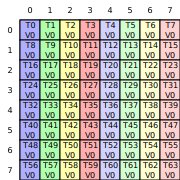

In [39]:
try:
    from cute_viz import display_tv_layout

    @cute.jit
    def visualize():
        # Create and render a layout to file
        # layout = cute.make_layout( ((16,16),(256,2)), stride=((512,8192),(1,256)))
        # display_layout(layout)
        tv_layout = cute.make_layout(
            ((8, 8), (1, 1)),
            stride=((8, 1), (0, 0))
        )
        print(tv_layout)
        display_tv_layout(tv_layout, (8, 8))

        # thr_block_layout = cute.make_layout((16, 256), stride=(512, 1))
        # print(cute.composition(thr_block_layout, tv_layout))

    visualize()
except ImportError:
    pass